# Imports

In [22]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import confusion_matrix,classification_report
import torch
from torch.utils.data import Dataset,Subset,DataLoader,random_split
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("darkgrid")

In [23]:
np.random.seed(42)
torch.manual_seed(42)

In [24]:
from deepchecks.vision.vision_data import BatchOutputFormat
from deepchecks.vision import VisionData
from deepchecks.vision.suites import data_integrity
from deepchecks.vision.suites import train_test_validation
from deepchecks.vision.suites import model_evaluation

# Configuration

In [25]:
root="/kaggle/input/alzheimer-mri-dataset/Dataset"
classes=['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

batch_size=16
device="cuda"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Dataset

In [26]:
print("dataset")

dataset


In [27]:
def loader(path):
    img=Image.open(path)
    img=np.array(img)
    if len(img.shape)==2:
        img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    return img
    
def valid_filepath(path):
    if path[-3:]=="jpg":
        return True
    else:
        False

In [28]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=5,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.Normalize(),
                           ToTensorV2()])
                           
test_transform=A.Compose([A.Normalize(),
                         ToTensorV2()])

class Transform():
    def __init__(self,transform):
        self.transform=transform
    def __call__(self,image):
        return self.transform(image=image)["image"]

In [29]:
dataset=ImageFolder(root,transform=Transform(test_transform),loader=loader,
                    is_valid_file=valid_filepath)

# Data Integrity Test

In [30]:
print("data integrity")

data integrity


In [31]:
LABEL_MAP={0:'Mild_Demented',
           1:'Moderate_Demented',
           2:'Non_Demented',
           3:'Very_Mild_Demented'}

def deepchecks_collate_fn(batch):
    batch = tuple(zip(*batch))
    inp = torch.stack(batch[0]).detach().numpy().transpose((0, 2, 3, 1))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    images = np.clip(inp, 0, 1) * 255

    labels = batch[1]
    return BatchOutputFormat(images=images, labels=labels)

In [32]:
dataloader=DataLoader(dataset,batch_size=16,collate_fn=deepchecks_collate_fn)
data=VisionData(batch_loader=dataloader, task_type='classification',label_map=LABEL_MAP)

# Train-Test Splitting

In [33]:
print("Splitting")

Splitting


In [34]:
train_idx,test_idx=random_split(range(len(dataset)),[0.75,0.25])

In [35]:
train_ds=ImageFolder(root,transform=Transform(train_transform),
                     loader=loader,is_valid_file=valid_filepath)
train_ds=Subset(train_ds,list(train_idx))

test_ds=ImageFolder(root,transform=Transform(test_transform),
                    loader=loader,is_valid_file=valid_filepath)
test_ds=Subset(test_ds,list(test_idx))

# Train-Test Validation Test

In [36]:
print("train test validating")

train test validating


In [37]:
train_dl=DataLoader(train_ds,batch_size=16,collate_fn=deepchecks_collate_fn)
training_data=VisionData(batch_loader=train_dl, task_type='classification',
                         label_map=LABEL_MAP)

test_dl=DataLoader(test_ds,batch_size=16,collate_fn=deepchecks_collate_fn)
test_data=VisionData(batch_loader=test_dl, task_type='classification',label_map=LABEL_MAP)

# Training

In [38]:
print("Training")

Training


In [39]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    pin_memory=True if device is "cuda" else False)
test_dl=DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                   pin_memory=True if device is "cuda" else False)

In [40]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]
    
def training(model,epochs,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,weights_path):
    best_val_acc=0.0
    patience=10
    best_weights=copy.deepcopy(model.state_dict())
    loss_dict={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
    
    for epoch in range(epochs):
        
        train_loss=0.0
        train_acc=0.0
        train_len=len(train_dl.dataset)
        val_loss=0.0
        val_acc=0.0
        val_len=len(val_dl.dataset)
        current_lr=get_lr(optimizer)
        
        model.train()
        for imgs,labels in train_dl:
            imgs,labels=imgs.to(device),labels.to(device)
            output=model(imgs)
            loss=loss_fn(output,labels)
            
            train_loss+=loss.item()
            pred_labels=output.argmax(dim=1)
            train_acc+=(labels==pred_labels).sum().item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        model.eval()
        with torch.no_grad():
            for imgs,labels in val_dl:
                imgs,labels=imgs.to(device),labels.to(device)
                output=model(imgs)
                loss=loss_fn(output,labels)
                
                val_loss+=loss.item()
                pred_labels=output.argmax(dim=1)
                val_acc+=(labels==pred_labels).sum().item()
            
        lr_scheduler.step(val_loss)
        if current_lr!=get_lr(optimizer):
            print("Loading best Model weights")
            model.load_state_dict(best_weights)
            
        if val_acc>best_val_acc:
            best_val_acc=val_acc
            best_weights=copy.deepcopy(model.state_dict())
            print("Updating Best Model weights")
            
        loss_dict["train_loss"].append(train_loss/train_len)  
        loss_dict["train_acc"].append(train_acc/train_len)
        loss_dict["val_loss"].append(val_loss/val_len)  
        loss_dict["val_acc"].append(val_acc/val_len)
        
        print(f"{epoch+1}/{epochs}: Training\nloss: {train_loss/train_len} accuracy: {train_acc/train_len}")
        print(f"{epoch+1}/{epochs}: Evaluating\nloss: {val_loss/val_len} accuracy: {val_acc/val_len}") 
        print("*"*50,"\n")
        
    torch.save(best_weights,weights_path)
    return loss_dict

In [41]:
def get_model(weights=None):
    model=efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    in_features=model.classifier[1].in_features
    model.classifier[1]=nn.Linear(in_features=in_features,out_features=4)
    model.to(device)
    
    return model

In [42]:
model=get_model()
optimizer=optim.Adam(model.parameters(),lr=3e-5,weight_decay=1e-4)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
finetuning_weights_path="/kaggle/working/finetuning_model.pth"

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 47.1MB/s]


In [43]:
loss_dict=training(model,50,train_dl,test_dl,optimizer,lr_scheduler,loss_fn,
                   finetuning_weights_path)

Updating Best Model weights
1/50: Training
loss: 1.1759199132521947 accuracy: 0.44708333333333333
1/50: Evaluating
loss: 0.9650797891616821 accuracy: 0.586875
************************************************** 

Updating Best Model weights
2/50: Training
loss: 0.9795432136456171 accuracy: 0.5329166666666667
2/50: Evaluating
loss: 0.9036837601661682 accuracy: 0.595
************************************************** 

Updating Best Model weights
3/50: Training
loss: 0.9220031915108363 accuracy: 0.55375
3/50: Evaluating
loss: 0.8397184431552887 accuracy: 0.60625
************************************************** 

Updating Best Model weights
4/50: Training
loss: 0.8866637120644252 accuracy: 0.5722916666666666
4/50: Evaluating
loss: 0.7778451606631279 accuracy: 0.631875
************************************************** 

Updating Best Model weights
5/50: Training
loss: 0.8552623150746027 accuracy: 0.5935416666666666
5/50: Evaluating
loss: 0.7448057514429093 accuracy: 0.658125
************

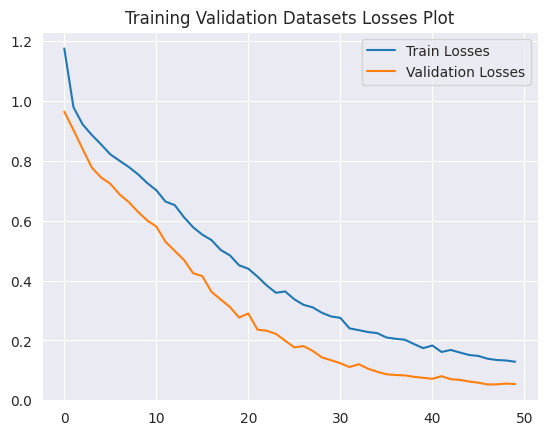

In [44]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

plt.savefig("1.png");

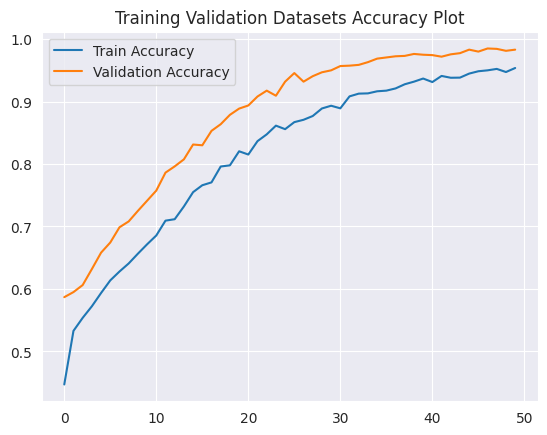

In [45]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

plt.savefig("2.png");

# Evaluation

In [46]:
model=get_model()
model.load_state_dict(torch.load("/kaggle/working/finetuning_model.pth"))

<All keys matched successfully>

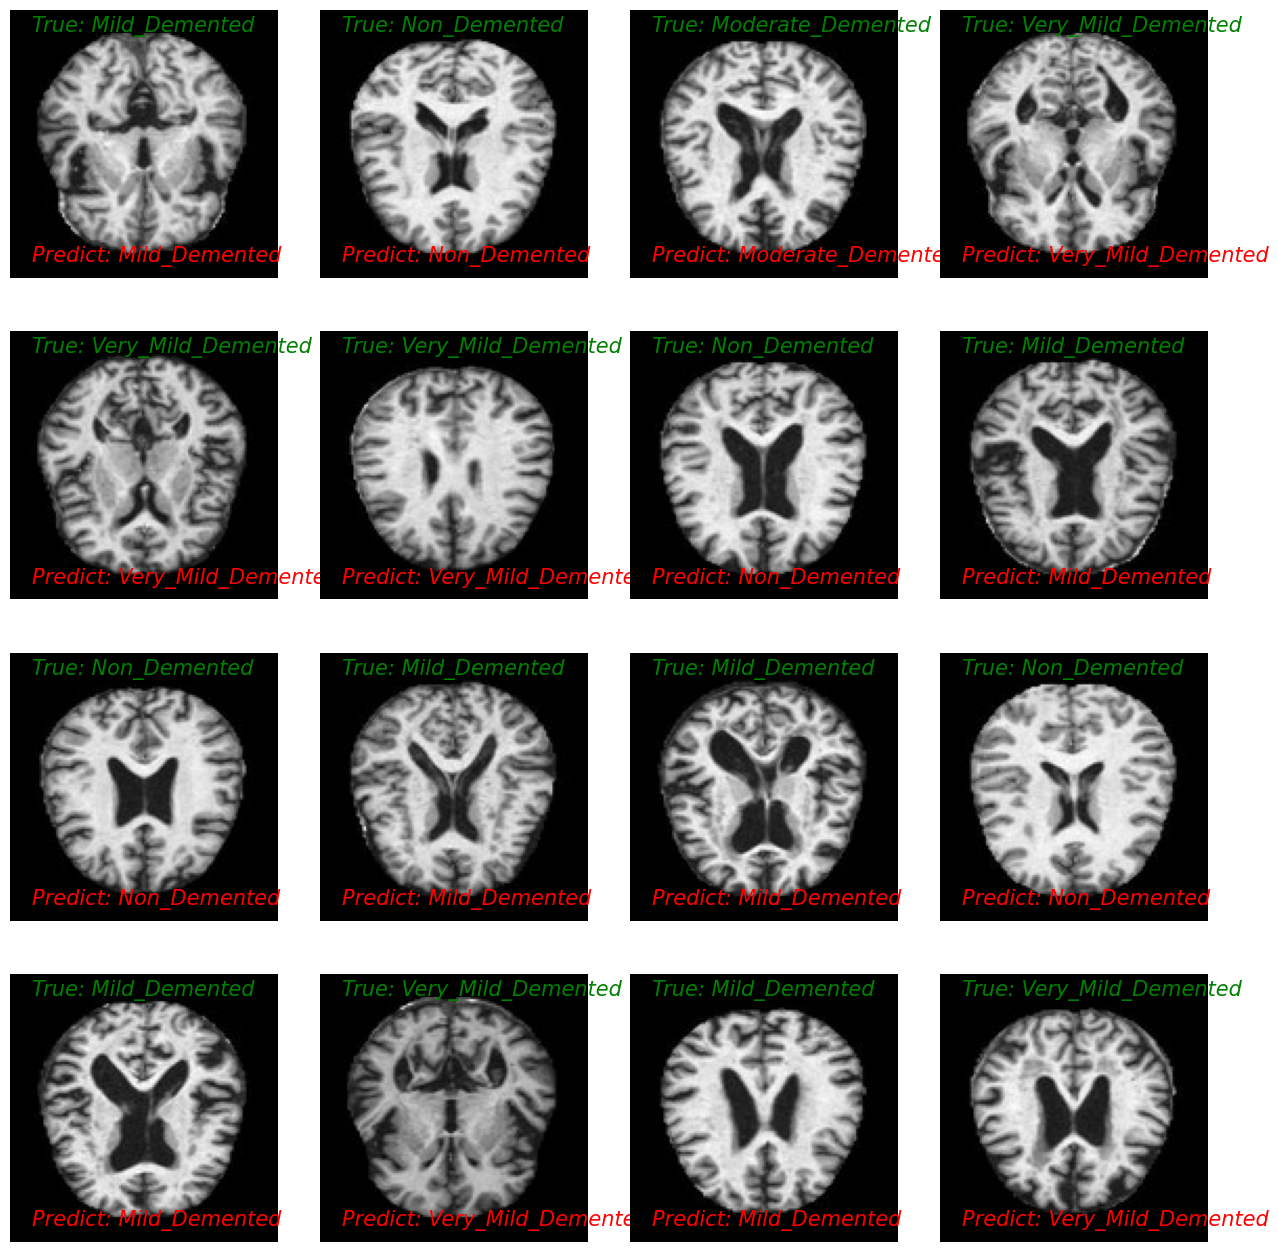

In [47]:
fig,axes=plt.subplots(4,4,figsize=(16,16))
plt.subplots_adjust(wspace=0)
ax=axes.flatten()

imgs,labels=next(iter(test_dl))
model.eval()
with torch.no_grad():
    imgs=imgs.to(device)
    output=model(imgs)

for i in range(imgs.shape[0]):
    pred_label=output[i].argmax(0)
    ax[i].imshow(imgs[i].permute(1,2,0).cpu().numpy()*std+mean)
    ax[i].text(10,10,"True: "+ classes[labels[i].item()],style ='italic',
               fontsize = 15, color ="green")
    ax[i].text(10,120,"Predict: "+ classes[pred_label.item()],style ='italic',
                fontsize = 15, color ="red")
    ax[i].axis("off")
    
plt.savefig("3.png");

# Model Validation

In [48]:
def model_validation_collate_fn(batch):
    batch = tuple(zip(*batch))
    inp = torch.stack(batch[0]).detach().numpy().transpose((0, 2, 3, 1))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    images = np.clip(inp, 0, 1) * 255

    labels = batch[1]

    #predictions:
    logits = model.to(device)(torch.stack(batch[0]).to(device))
    predictions = nn.Softmax(dim=1)(logits)
    return BatchOutputFormat(images=images, labels=labels, predictions=predictions)

In [50]:
train_loader=DataLoader(train_ds, batch_size=16, shuffle=True,
                        collate_fn=model_validation_collate_fn)
test_loader=DataLoader(test_ds, batch_size=16, shuffle=True,
                        collate_fn=model_validation_collate_fn)

training_data=VisionData(batch_loader=train_loader, task_type='classification', 
                        label_map=LABEL_MAP)
test_data=VisionData(batch_loader=test_loader, task_type='classification', 
                    label_map=LABEL_MAP)